# Original idea from here: https://habr.com/ru/articles/671778/

Compute covariance matrix for pixels channels in intermediate layers of model. Find Eigenvalues of matrices: https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix
If layer has too much filters at output, eigenvalues will have hude difference.
if layers filters all have valueable information, eigenvalues will be quite big.

After checking eigenvalues it's possible to find and eliminate bottlenecks in neural model.


In [1]:
import time
from typing import Optional, Tuple, List,  Dict, Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import colorsys

from myutil import CovarianceAccumulator

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class MyConvModel(nn.Module):
    def __init__(self, channels: int):
        super(MyConvModel, self).__init__()

        c = channels
        self.layers = nn.Sequential(
            self.conv(1, c, kernel_size=3),  # 28 - 26
            self.conv(c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            self.conv(c, c * 2, kernel_size=3),  # 12 - 10
            self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def flat_layers(self) -> List[nn.Module]:
        def walk(module: nn.Module) -> nn.Module:
            if isinstance(module, nn.Sequential):
                for child in module.children():
                    yield from walk(child)
            else:
                yield module

        return list(walk(self.layers))

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [6]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int = 2048,
              device_name: str = 'cuda') -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test_covariance(cnn: 'MyConvModel',
                        test_dataset: datasets.MNIST,
                        device=None) -> Dict[str, CovarianceAccumulator]:
        flat_layers = cnn.flat_layers()
        stats: Dict[nn.Module, CovarianceAccumulator] = {}
        stats['input'] = CovarianceAccumulator()
        for layer in flat_layers:
            stats[layer] = CovarianceAccumulator()
            
        def convert(tensor: torch.Tensor) -> np.ndarray:
            arr = tensor.detach().cpu().numpy()
            if len(arr.shape) == 4:
            # shape = batch, channels, x, y
                arr = np.moveaxis(arr, 1, 3)
                arr = np.reshape(arr, (-1, arr.shape[3]))
            assert len(arr.shape) == 2
            return arr

        with torch.no_grad():
            loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
            for images, _ in loader:
                if device is not None:
                    images = images.to(device)

                x = images
                stats['input'].add_samples(convert(x))
                for module in flat_layers:
                    x = module(x)
                    stats[module].add_samples(convert(x))

        return stats

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        with torch.no_grad():
            for images, labels in loader:
                if device is not None:
                    images = images.to(device)

                results = cnn(images)
                predictions = results.detach().cpu().numpy().argmax(axis=1)
                oks = (predictions == labels.numpy()).sum()
                correct += oks
                incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

    @staticmethod
    def show_stats(stats: Dict[nn.Module, CovarianceAccumulator], layers_filter: Callable[[nn.Conv2d], bool]):
        plt.rcParams['figure.figsize'] = [12, 12]
        fig, ax = plt.subplots()
        ax.set_yscale("log")
    
        for i, (module, stat) in enumerate([(m, s) for m, s in stats.items() if layers_filter(m)]):
            eigenvalues = stat.eigenvalues
            x = list(range(len(eigenvalues)))
            color = colorsys.hsv_to_rgb(i * 0.08, 1.0, 1.0)
            ax.plot(x, eigenvalues, c=color)
    
        plt.show()
        
    @staticmethod
    def show_stats_conv(stats: Dict[nn.Module, CovarianceAccumulator]):
        TrainHelper.show_stats(stats, lambda m: isinstance(m, nn.Conv2d))

    @staticmethod
    def show_stats_relu(stats: Dict[nn.Module, CovarianceAccumulator]):
        TrainHelper.show_stats(stats, lambda m: isinstance(m, (nn.LeakyReLU, nn.Flatten)))

epoch 0, accuracy = 0.7404, loss = 1.0235204696655273
epoch 1, accuracy = 0.9533, loss = 0.6038817763328552
epoch 2, accuracy = 0.9734, loss = 0.3772363066673279
epoch 3, accuracy = 0.9817, loss = 0.25025808811187744
epoch 4, accuracy = 0.9849, loss = 0.16954630613327026
epoch 5, accuracy = 0.9878, loss = 0.1138531044125557
epoch 6, accuracy = 0.9896, loss = 0.09587584435939789
epoch 7, accuracy = 0.9911, loss = 0.08953706920146942
epoch 8, accuracy = 0.9916, loss = 0.06263426691293716
epoch 9, accuracy = 0.9914, loss = 0.05692872405052185


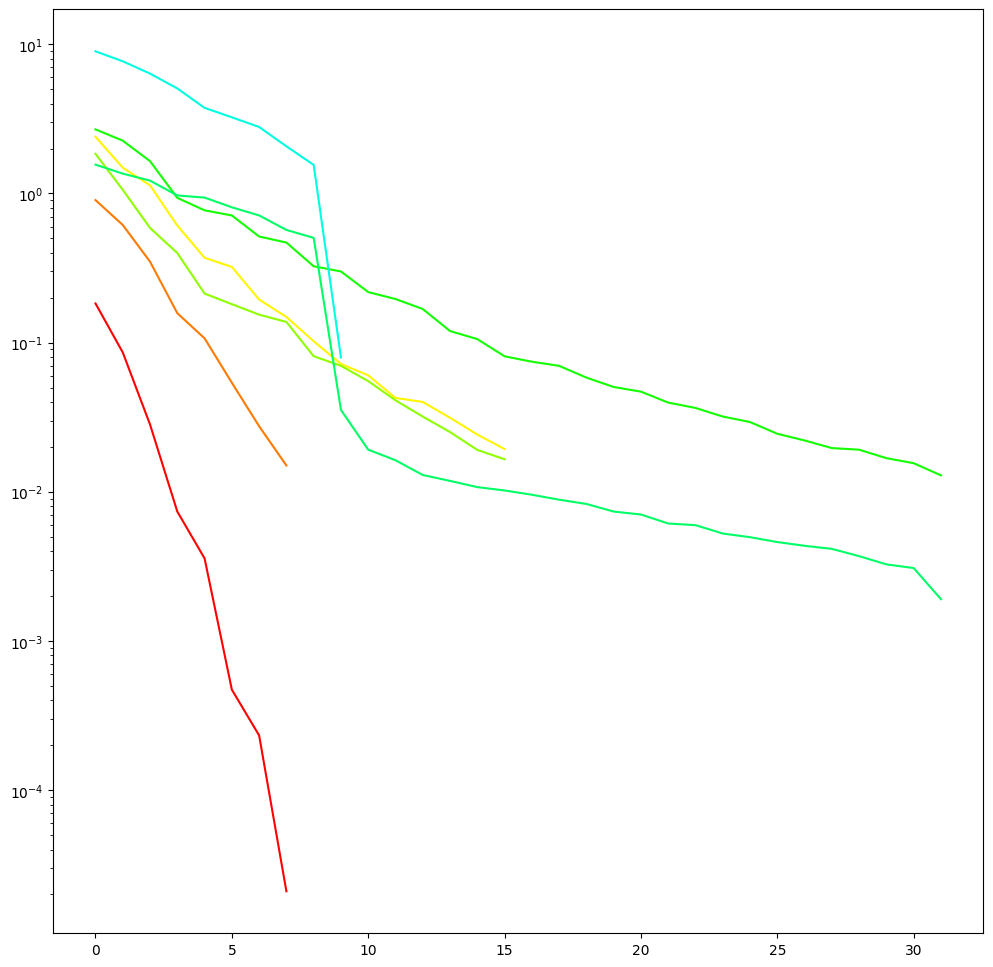

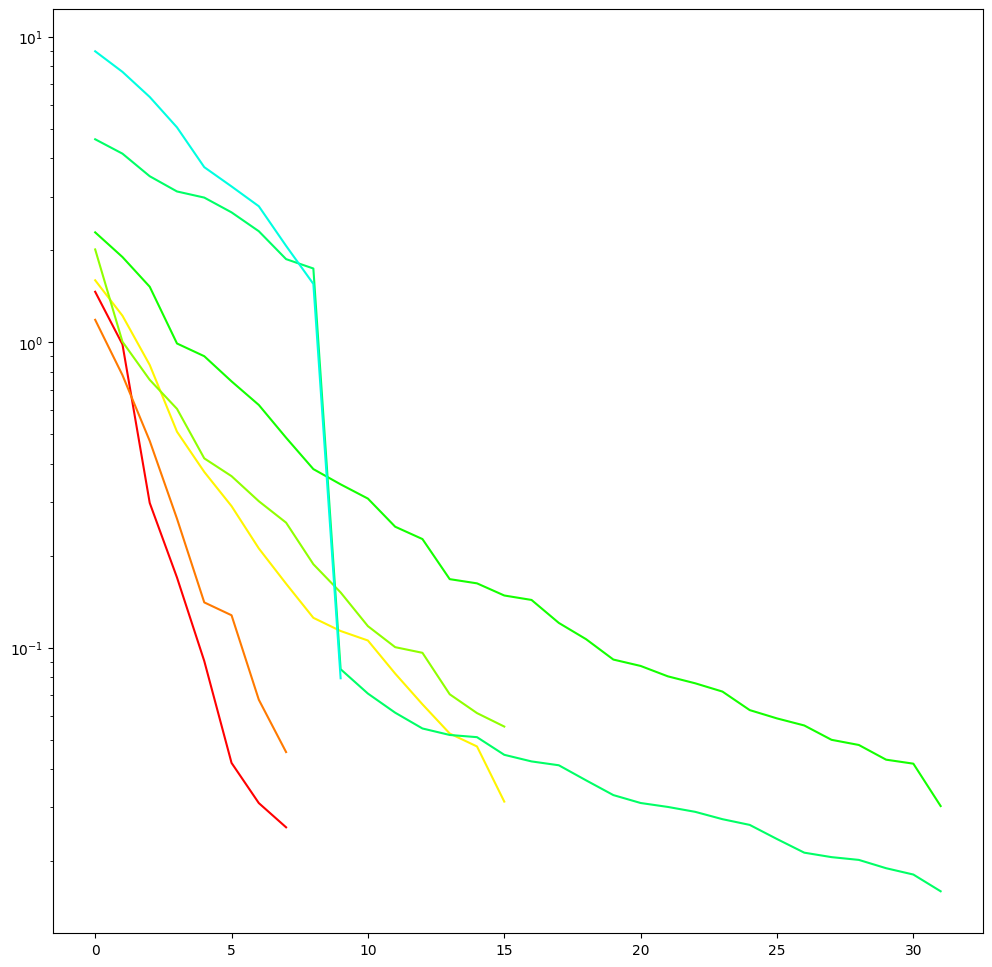

In [7]:
model = MyConvModel(8).to('cuda')
_ = TrainHelper.train(model, 
                  epochs=10, 
                  train_dataset=train_data, 
                  test_dataset=test_data)
stats = TrainHelper.test_covariance(model, test_data, device='cuda')
TrainHelper.show_stats_conv(stats)
TrainHelper.show_stats_relu(stats)

epoch 0, accuracy = 0.1764, loss = 1.3755450248718262
epoch 1, accuracy = 0.929, loss = 1.112460732460022
epoch 2, accuracy = 0.9654, loss = 0.877631425857544
epoch 3, accuracy = 0.9768, loss = 0.6793000102043152
epoch 4, accuracy = 0.984, loss = 0.5271845459938049
epoch 5, accuracy = 0.9868, loss = 0.41661471128463745
epoch 6, accuracy = 0.9883, loss = 0.317061185836792
epoch 7, accuracy = 0.9907, loss = 0.26030996441841125
epoch 8, accuracy = 0.9909, loss = 0.2136119306087494
epoch 9, accuracy = 0.9912, loss = 0.16849413514137268


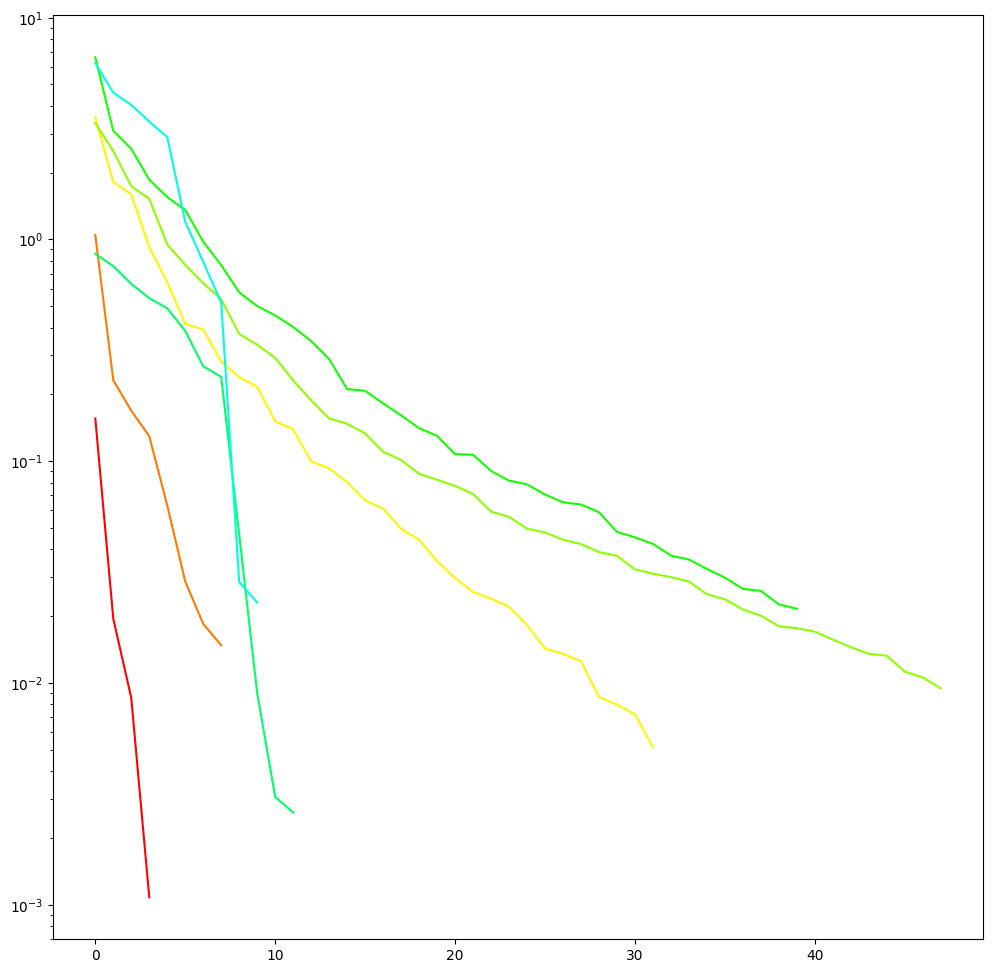

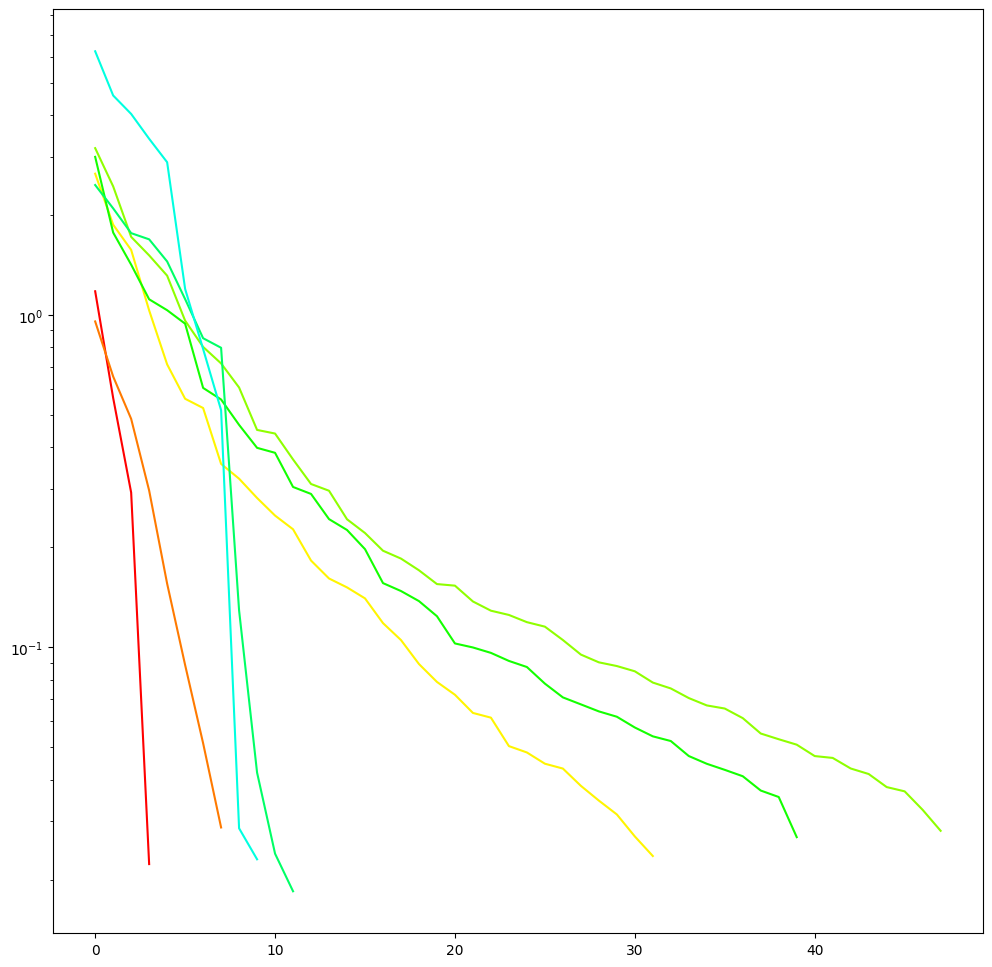

In [8]:
class MyTunedConvModel(nn.Module):
    def __init__(self):
        super(MyTunedConvModel, self).__init__()

        self.layers = nn.Sequential(
            self.conv(1, 4, kernel_size=3),  # 28 - 26
            self.conv(4, 8, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            self.conv(8, 32, kernel_size=3),  # 12 - 10
            self.conv(32, 48, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            self.conv(48, 40, kernel_size=3),  # 4 - 2
            self.conv(40, 12, kernel_size=2),  # 2 - 1

            nn.Conv2d(12, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def flat_layers(self) -> List[nn.Module]:
        def walk(module: nn.Module) -> nn.Module:
            if isinstance(module, nn.Sequential):
                for child in module.children():
                    yield from walk(child)
            else:
                yield module

        return list(walk(self.layers))

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

model_tuned = MyTunedConvModel()

TrainHelper.train(model_tuned,
                  epochs=10,
                  train_dataset=train_data,
                  test_dataset=test_data,)

tuned_stats = TrainHelper.test_covariance(model_tuned, test_data, device='cuda')
TrainHelper.show_stats_conv(tuned_stats)
TrainHelper.show_stats_relu(tuned_stats)

epoch 0, accuracy = 0.4029, loss = 0.06860054284334183
epoch 1, accuracy = 0.9868, loss = 0.026642024517059326
epoch 2, accuracy = 0.9916, loss = 0.03273332491517067
epoch 3, accuracy = 0.9912, loss = 0.011635596863925457
epoch 4, accuracy = 0.9932, loss = 0.009281774051487446
epoch 5, accuracy = 0.9933, loss = 0.01020980067551136
epoch 6, accuracy = 0.9936, loss = 0.012274944223463535
epoch 7, accuracy = 0.9919, loss = 0.003328650025650859
epoch 8, accuracy = 0.9922, loss = 0.0026151917409151793
epoch 9, accuracy = 0.9948, loss = 0.0011374778114259243


/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


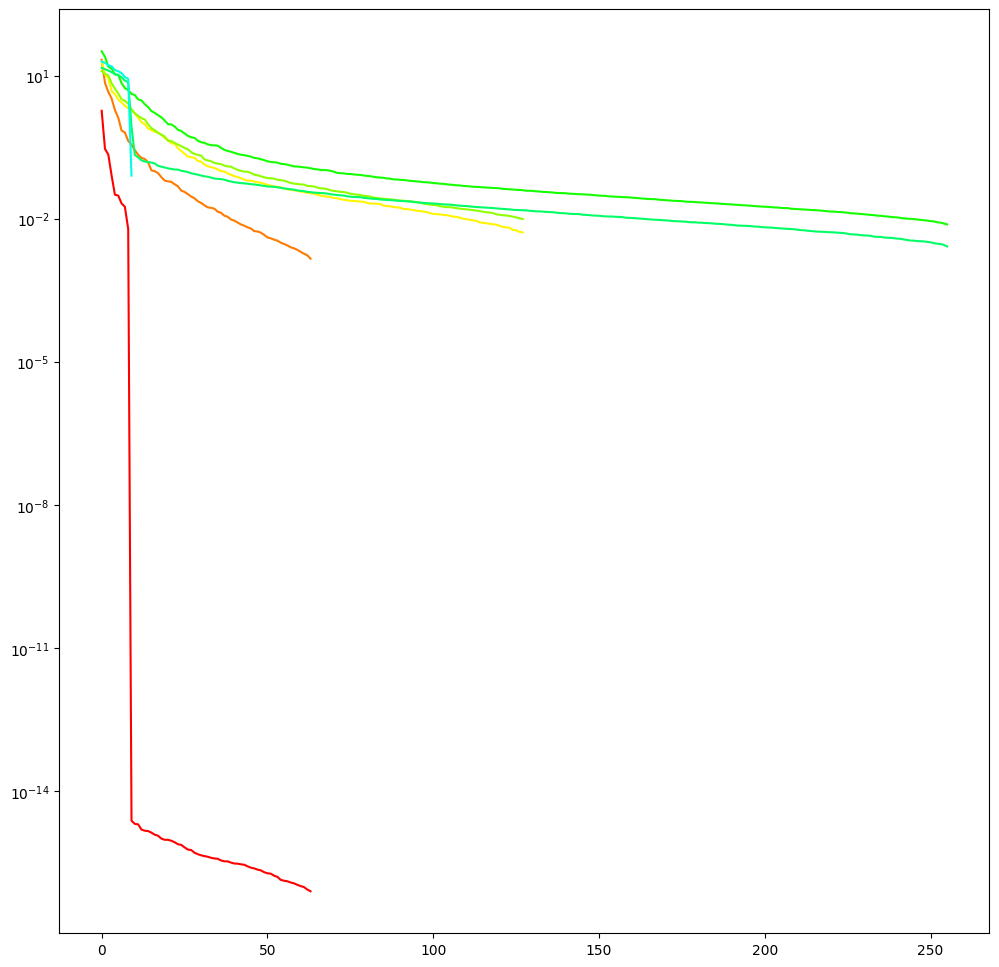

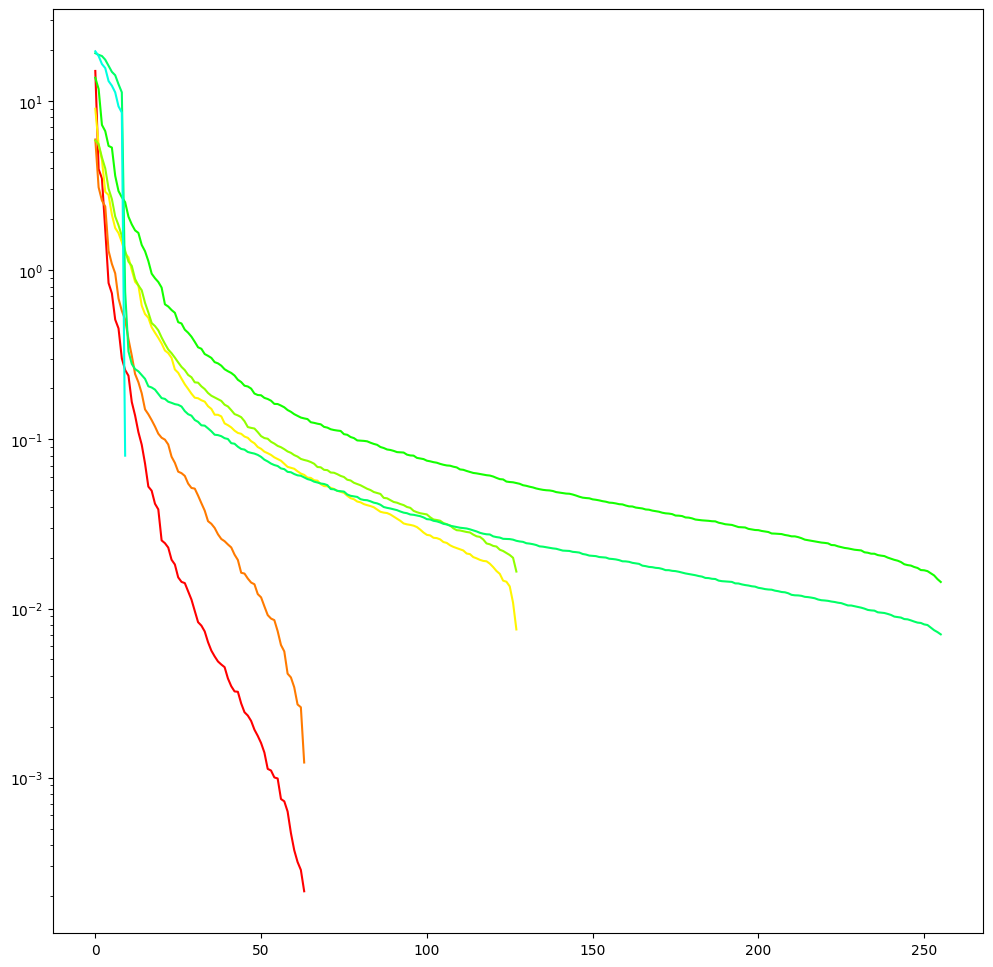

In [9]:
model_wide = MyConvModel(64).to('cuda')
_ = TrainHelper.train(model_wide, 
                      epochs=10, 
                      train_dataset=train_data, 
                      test_dataset=test_data)
stats_wide = TrainHelper.test_covariance(model_wide, test_data, device='cuda')
TrainHelper.show_stats_conv(stats_wide)
TrainHelper.show_stats_relu(stats_wide)

## Tuned wide model architecture

I only decrease channels count, don't increase.
Decision is based on eigenvalues after activation layer.

I changed two first layers and two last. On the chart with eigenvalues after activation all lines truncated on nearly same values. 

epoch 0, accuracy = 0.5985, loss = 0.44661226868629456
epoch 1, accuracy = 0.9826, loss = 0.19936877489089966
epoch 2, accuracy = 0.9915, loss = 0.11651607602834702
epoch 3, accuracy = 0.9929, loss = 0.08157522976398468
epoch 4, accuracy = 0.9941, loss = 0.05199788510799408


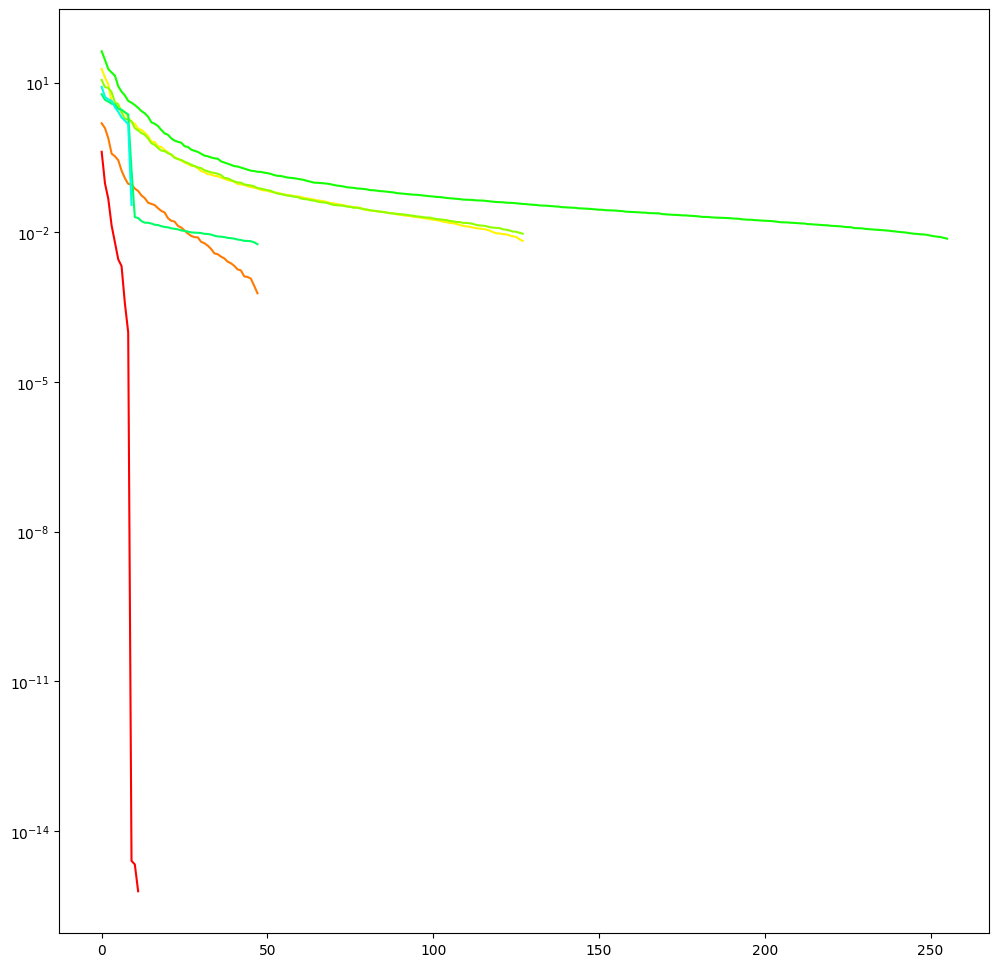

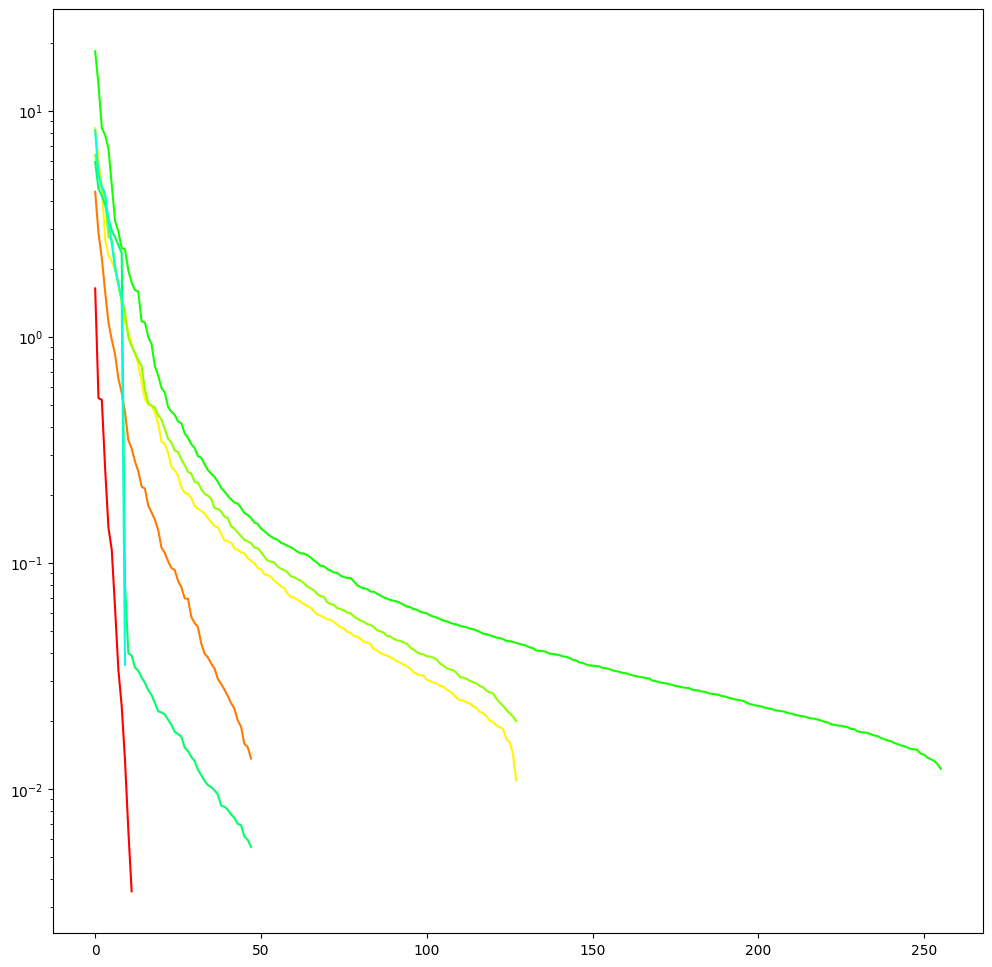

In [10]:
class MyConvModelWideTuned(nn.Module):
    def __init__(self):
        super(MyConvModelWideTuned, self).__init__()

        self.layers = nn.Sequential(
            self.conv(1, 12, kernel_size=3),  # 28 - 26
            self.conv(12, 48, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            self.conv(48, 64 * 2, kernel_size=3),  # 12 - 10
            self.conv(64 * 2, 64 * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            self.conv(64 * 2, 64 * 4, kernel_size=3),  # 4 - 2
            self.conv(64 * 4, 48, kernel_size=2),  # 2 - 1

            nn.Conv2d(48, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def flat_layers(self) -> List[nn.Module]:
        def walk(module: nn.Module) -> nn.Module:
            if isinstance(module, nn.Sequential):
                for child in module.children():
                    yield from walk(child)
            else:
                yield module

        return list(walk(self.layers))

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

model_wide_tuned = MyConvModelWideTuned().to('cuda')
TrainHelper.train(model_wide_tuned,
                  epochs=5,
                  train_dataset=train_data,
                  test_dataset=test_data)
model_wide_tuned = TrainHelper.test_covariance(model_wide_tuned, test_data, device='cuda')
TrainHelper.show_stats_conv(model_wide_tuned)
TrainHelper.show_stats_relu(model_wide_tuned)

In [11]:
r_wide_tuned = [TrainHelper.train(
    MyConvModelWideTuned(), 
    epochs=5, 
    train_dataset=train_data, 
    test_dataset=test_data,
    print_results=False
)[-1] for _ in range(5)]
r_wide_tuned

[0.9934, 0.9936, 0.9941, 0.9939, 0.9932]

In [12]:
r_wide_original = [TrainHelper.train(
    MyConvModel(64), 
    epochs=5, 
    train_dataset=train_data, 
    test_dataset=test_data,
    print_results=False
)[-1] for _ in range(5)]
r_wide_original

[0.992, 0.9924, 0.9936, 0.992, 0.9931]

In [13]:
np.average(r_wide_tuned), np.average(r_wide_original) 

(0.9936400000000001, 0.99262)